## Load Training Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

%matplotlib inline

# make plots look betters
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['figure.dpi'] = (300)
plt.rcParams['font.size'] = 12

comments = pd.read_pickle('../toxic_comment_data/combined_train_data.csv')

## Feature Extraction

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

# allows us to select a column by name from a data frame and return it as a nparray of type string
class TextExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def transform(self, data):
        return np.asarray(data[self.column]).astype(str)
    
    # not used
    def fit(self, *_):
        return self 

# allows us to select a column by name from a data frame and return it as a nparray of the specified type
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column, dtype):
        self.dtype = dtype
        self.column = column

    def transform(self, data):
        data = np.asarray(data[self.column]).astype(self.dtype)
         
        # note: reshaping is necessary because otherwise sklearn
        # interprets 1-d array as a single sample
        # reshapes from row vector to column vector
        data = data.reshape(data.size, 1) 
        return data
    
    # not used
    def fit(self, *_):
        return self

In [3]:
char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer())
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('tfidf', TfidfTransformer())
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
classifier = DummyClassifier(strategy='most_frequent')

# set the feature selection
select = SelectPercentile(score_func=chi2, percentile=25)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [4]:
pipeline.fit(comments, comments.Insult);

In [11]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
 
prediction = pipeline.predict(comments)
precise = precision_score(comments.Insult, prediction)
recall = recall_score(comments.Insult, prediction)
auc1 = roc_auc_score(comments.Insult, prediction)
print('precision: ', str(precise), ', recall: ', str(recall), ', auc: ', str(auc1))

precision:  0.0 , recall:  0.0 , auc:  0.5


/Users/rrvdw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
# make a function for plotting the roc
def plot_roc(test_labels, predicted_labels):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels,predicted_labels)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('ROC for DummyClassifier')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

In [16]:
test = pd.read_pickle("../toxic_comment_data/labeled_test_set_with_features.csv")
predicted = pipeline.predict(test)
np.mean(predicted == test.Insult)

0.51812080536912752

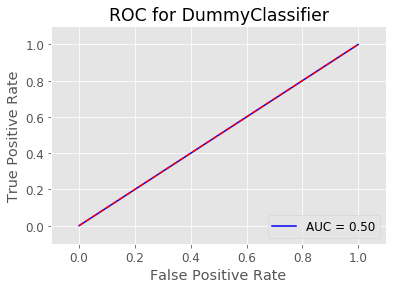

In [17]:
plot_roc(test.Insult, predicted)

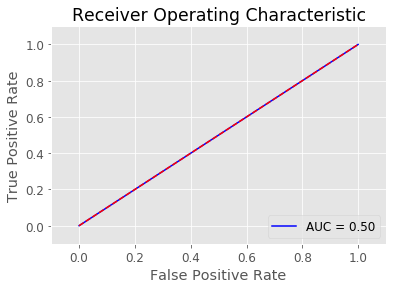

In [9]:
predicted_dummy = pipeline.predict(comments)
predicted = [0]*len(predicted_dummy)
plot_roc(comments.Insult, predicted)

In [10]:
from sklearn.externals import joblib
joblib.dump(gs_clf2, 'gs_clf2_new.pkl');

NameError: name 'gs_clf2' is not defined